In [142]:
import numpy as np
import pandas as pd
from pygimli.meshtools import readGmsh
import pygimli as pg
import glob

from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
from itertools import combinations
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, cKDTree
from pygimli.physics import ert
from ertoolbox import inversion
from ertoolbox import ert_postprocessing


In [150]:
folder = 'p:/11209233-mad09a2023ijsselmeer3d/C_Work/02_FM/03_postprocessing/09_input_tomografische_metingen/voorhaven_kwz/sal_tem'
counter = 0
for csv in glob.glob(f"{folder}/*.csv"):
    counter+=1
    if counter == 5:
        data = pd.read_csv(csv)
# csv = '../data/testgrid.csv'
# data = pd.read_csv(csv)
print(data, csv)



     Distance [m]   Z [m NAP]   Salinity [psu]   Temperature [degC]
0           12.99      -1.564             0.65                18.98
1           12.99      -1.505             0.65                18.98
2           12.99      -1.388             0.65                18.98
3           12.99      -1.270             0.65                18.98
4           12.99      -1.152             0.65                18.98
..            ...         ...              ...                  ...
563         98.94      -0.691             0.62                18.92
564         98.94      -0.571             0.62                18.91
565         98.94      -0.450             0.62                18.91
566         98.94      -0.330             0.62                18.88
567         98.94      -0.270             0.62                18.88

[568 rows x 4 columns] p:/11209233-mad09a2023ijsselmeer3d/C_Work/02_FM/03_postprocessing/09_input_tomografische_metingen/voorhaven_kwz/sal_tem\crosssection_sal_tem_20220803_0000.csv


In [151]:
data.columns =['x', 'z', 'salinity', 'temperature'] #for now these columns are nesseccary!!
# data.columns =['x', 'y', 'z', 'resistivity'] 

In [152]:
data["resistivity"] = 1 / ert_postprocessing.salinity_to_conductivity(
        data["salinity"], data["temperature"]
    )

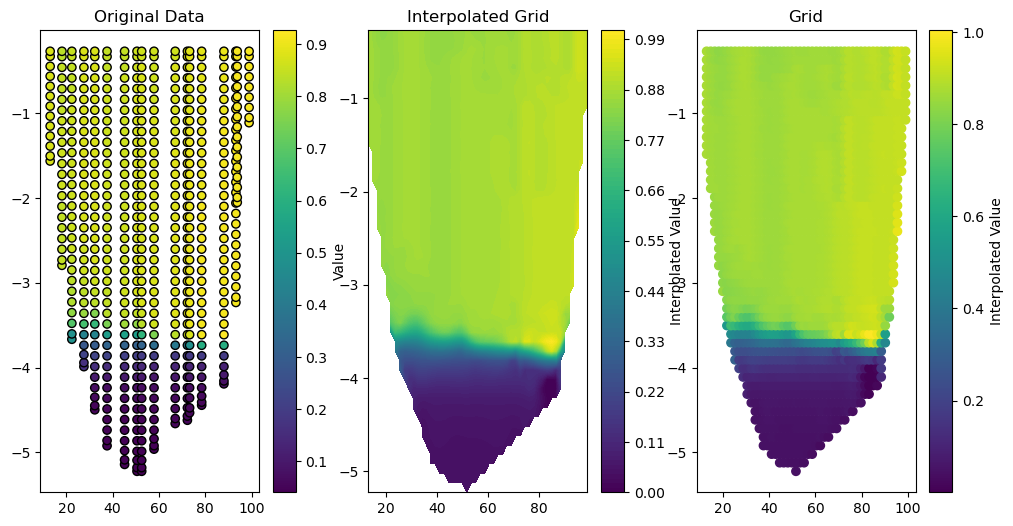

In [153]:
# Define grid parameters
x_min, x_max = data['x'].min(), data['x'].max()
z_min, z_max = data['z'].min(), data['z'].max()
grid_size = 50  # Number of grid points along each axis

# Create a regular grid
x_grid = np.linspace(x_min, x_max, grid_size)
z_grid = np.linspace(z_min, z_max, grid_size)
X_grid, Z_grid = np.meshgrid(x_grid, z_grid)
Y_grid = np.zeros(np.shape(X_grid))

# Stack grid data
xyz = np.column_stack([X_grid.flatten(),Z_grid.flatten()])

# Prepare data for interpolation
points = data[['x', 'z']].values #change to interpolated points
values = data['resistivity'].values

# Interpolate
grid_values = griddata(points, values, (X_grid, Z_grid), method='cubic')
grid_values[grid_values<0] = 0.001


# Plot original points
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(data['x'], data['z'], c=data['resistivity'], cmap='viridis', edgecolor='k')
plt.title('Original Data')
plt.colorbar(label='Value')

# Plot interpolated grid
plt.subplot(1, 3, 2)
plt.contourf(X_grid, Z_grid, grid_values, levels=100, cmap='viridis')
plt.title('Interpolated Grid')
plt.colorbar(label='Interpolated Value')
# X_grid = data['x']
# Z_grid = data['z']
# grid_values = data['salinity']
plt.subplot(1, 3, 3)
plt.scatter(X_grid, Z_grid, c=grid_values)
plt.title('Grid')
plt.colorbar(label='Interpolated Value')
plt.show()

In [154]:
# Create a DataFrame
df = pd.DataFrame(
    {"x": X_grid.flatten(), "z": Z_grid.flatten(), "value": grid_values.flatten()}
) 
from scipy import interpolate

# Only use valid data points
df = df.dropna()
# #take 1 node above the bottom
min_z_indices = df.groupby('x')['z'].idxmin()
df = df.drop(min_z_indices)
df.reset_index(drop=True, inplace=True)

min_z_indices = df.groupby("x")["z"].idxmin()
min_z_df = df.loc[min_z_indices]
min_z_df.reset_index(drop=True, inplace=True)

x_points = min_z_df['x']
z_points = min_z_df['z']
# Interpolation
distance = 1  # cm

# Calculate the distances between the original points
distances = np.sqrt(np.diff(x_points)**2 + np.diff(z_points)**2)

# Calculate cumulative distances
cumulative_distances = np.concatenate(([0], np.cumsum(distances)))

# New distance points from the start to the end
new_distances = np.arange(0, cumulative_distances[-1], distance)

# Interpolating
new_x = np.interp(new_distances, cumulative_distances, x_points)
new_z = np.interp(new_distances, cumulative_distances, z_points)

# Resulting interpolated points
interpolated_points = np.column_stack((new_x, new_z))


def calculate_distances(points):
    """
    Calculate distances between consecutive points.

    Parameters:
    points (array-like): A 2D array or list of points where each point is represented as [x, y].

    Returns:
    np.ndarray: An array of distances between consecutive points.
    """
    points = np.array(points)  # Ensure the input is a NumPy array
    # Calculate the distances between consecutive points
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
    return distances


distances = calculate_distances(interpolated_points)


In [155]:
print(np.shape(xyz), np.shape(points))

(2500, 2) (568, 2)


[       nan        nan 0.8257556  ... 0.85523522 0.85637869 0.85534262]


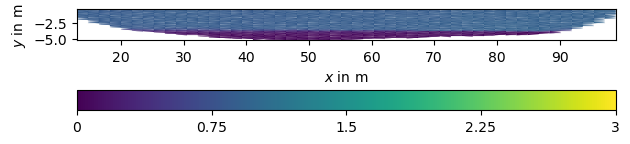

In [156]:
# Create 2D Pygimli  mesh
mesh = pg.Mesh(2)

cs = []
cr = []

# Make nodes for all datapoints
for p in xyz:
    c = mesh.createNode((p[0],p[1]))
    cs.append(c)

# # # make nodes for all electrodes:  
# for pt in interpolated_points:
#     c = mesh.createNode((pt[0],pt[1]))
#     cs.append(c)

# Triangulate points into mesh with triangles
tri = Delaunay(xyz)
triangles = tri.simplices

# Calculate centroids of the triangles
centroids = np.array([np.mean(xyz[tri.simplices[i]], axis=0) for i in range(len(tri.simplices))])

# Find closest grid point to the triangle
tree = cKDTree(xyz)
distances, indices = tree.query(centroids)

# # Add value to the grid cell

triangle_values = grid_values.flatten()[indices]
print(triangle_values)
# Add triangles to mesh object
tlist = []
for t in range(0,len(triangles)):
    mesh.createTriangle(cs[triangles[t][0]],cs[triangles[t][1]],cs[triangles[t][2]], marker = t)  #marker is value  
    tlist = np.append(tlist,t)

# Add boundaries
mesh.createNeighborInfos()

# mesh = pg.meshtools.appendTriangleBoundary(mesh)
listc = list(range(1, len(triangle_values) + 1))
plotdata = np.array([[a, b] for a, b in zip(listc, triangle_values)])

# Plot mesh with values
ax, cb = pg.viewer.showMesh(mesh, data = triangle_values, cMin = 0, cMax = 3)



05/11/24 - 11:58:24 - pyGIMLi - INFO - Data error estimate (min:max)  nan : nan


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1b235e14290>)

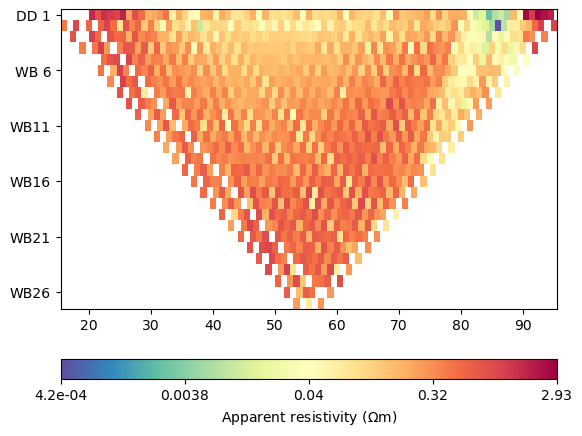

In [157]:
# Define electrode positions TODO
EZ = new_z
EX = new_x
electrodes = [[x, y] for x, y in zip(EX, EZ)]

# Create measurement scheme
scheme_dd = ert.createData(elecs=electrodes, schemeName='wb')

# Make simulation data
simdata = ert.simulate(
         mesh=mesh, scheme=scheme_dd, res = triangle_values, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337
    )
simdata.remove(simdata["rhoa"] < 0)
ert.show(simdata)

05/11/24 - 11:58:32 - pyGIMLi - INFO - Found 4802 regions.
05/11/24 - 11:58:32 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (0) set to background.
05/11/24 - 11:58:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
05/11/24 - 11:58:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
05/11/24 - 11:58:32 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 9801 Cells: 19208 Boundaries: 14602
05/11/24 - 11:58:33 - pyGIMLi - INFO - Use median(data values)=0.26972209287008897
05/11/24 - 11:58:33 - pyGIMLi - INFO - Created startmodel from forward operator: 4801, min/max=0.269722/0.269722
05/11/24 - 11:58:33 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001B2CA5A6B60>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001B2C8B4EBB0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001B2C8B4E8E0>
min/max (data): 4.2e-04/2.93
min/max (error): 1%/9.43%
min/max (start model): 0.27/0.27
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 6747.64
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 4610.34 (dPhi = 31.52%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 4284.33 (dPhi = 7.02%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 3986.73 (dPhi = 6.81%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 3776.74 (dPhi = 5.10%) lam: 20.0
-------------

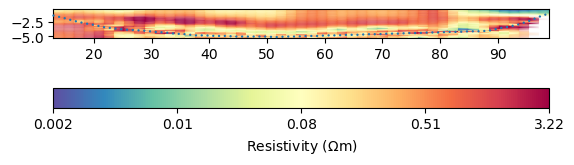

In [158]:

# simdata.remove(simdata["rhoa"] == np.inf)
# simdata.remove(simdata["rhoa"] == np.nan)

maxclim = max(simdata['rhoa']) * 1.1
#Inverse for check
inversion_dd_1 = inversion(simdata, mesh , cmin=0, cmax= maxclim, saveresult=False)
